# Leaf Disease Classification

## Pepper Leaf Disease classification Model Training

### Import all the Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

### Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3  # denotes the number of color channels in the image
EPOCHS=25

### Reading and Generating the Train, Test and Validation data using ImageDataGenerator

##### We will use ImageDataGenerator api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory('DataSets/Pepper/train', 
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                   batch_size=32,
                                                   class_mode="categorical")

Found 1731 images belonging to 2 classes.


In [4]:
validation_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory('DataSets/Pepper/val', 
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                   batch_size=32,
                                                   class_mode="categorical")

Found 370 images belonging to 2 classes.


In [5]:
test_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, horizontal_flip=True)
test_generator = test_datagen.flow_from_directory('DataSets/Pepper/test', 
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                   batch_size=32,
                                                   class_mode="categorical")

Found 374 images belonging to 2 classes.


### Knowing the DataStructure

In [6]:
total_samples = train_generator.n
batch_size = train_generator.batch_size

print(f'The train_generator consists {total_samples} image data with their labels.' )
print(f'The {total_samples} images are stored in batches of size {batch_size}.')

# Calculate the number of batches
num_batches_train = total_samples // batch_size

# If there are remaining samples that don't complete a full batch, add one more batch
if total_samples % batch_size != 0:
    num_batches_train += 1

print("Total number of batches in train_generator:", num_batches_train)

The train_generator consists 1731 image data with their labels.
The 1731 images are stored in batches of size 32.
Total number of batches in train_generator: 55


In [7]:
# Lets Load a batch and explore it
batch = train_generator.next()
print(f'The batch consists of {len(batch)} elements a images_batch and a labels_batch of 32 samples max:' )
print('-'*108)
print('The batch size is 32 and image shape is 256*256 in rbg format(3):\n', batch[0].shape)
print()
print(f'Since we used class_mode="categorical" our labels are OneHot encoded {batch[1][0]}.')
print('The labels of 32 images in a batch are :\n', [np.argmax(pred_prob)for pred_prob in batch[1]])

The batch consists of 2 elements a images_batch and a labels_batch of 32 samples max:
------------------------------------------------------------------------------------------------------------
The batch size is 32 and image shape is 256*256 in rbg format(3):
 (32, 256, 256, 3)

Since we used class_mode="categorical" our labels are OneHot encoded [0. 1.].
The labels of 32 images in a batch are :
 [1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1]


In [8]:
classes = list(train_generator.class_indices.keys())
print(f'Number of classes {len(classes)}')
print(classes)

Number of classes 2
['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']


In [6]:
class_names = ['Pepper bell Bacterial spot', 'Pepper bell healthy']

(-0.5, 255.5, 255.5, -0.5)

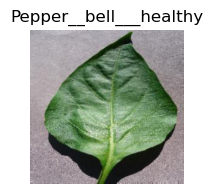

In [10]:
images_batch, labels_batch = batch
image1 = images_batch[0]
label1 = labels_batch[0]

plt.figure(figsize=(2, 2))
plt.imshow(image1)
plt.title(classes[np.argmax(label1)])
plt.axis('off') 

## Building the Model

### Model Architecture
1. We use a CNN coupled with a sigmoid activation in the output layer. 
2. Use `train_generator`, `validation_generator` to resize and scale data; and also generate augmented data

In [11]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),  # Adding dropout with a rate (adjust rate as needed)
    layers.Dense(n_classes, activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

### Compiling the Model
We use `adam` Optimizer, `CategoricalCrossentropy` for losses, `accuracy` as a metric

* Use the BinaryCrossentropy loss function for a binary classification task. 
* We will get predicted probailities as output. We will take the argmax of the instance to know which one is the most confident prediction.

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [13]:
# steps_per_epoch = total_samples / batch_size 
num_batches_train  # we already calculated above

55

In [14]:
# For validation_steps  (total_samples / batch_size)

num_batches_val = validation_generator.n // validation_generator.batch_size
if total_samples % batch_size != 0: # If there are remaining samples that don't complete a full batch, add one more batch
    num_batches_val += 1
    
num_batches_val

12

In [15]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)


# Convert to a dictionary to be used in model.fit
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.2417503586800573, 1: 0.8370406189555126}

In [16]:
# Train the model with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=55,  # num_batches_train
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=12,  # num_batches_val
    verbose=1,
    epochs=EPOCHS,
    class_weight=class_weights_dict
)

Epoch 1/25
55/55 [==============================] - 129s 2s/step - loss: 0.6305 - accuracy: 0.5864 - val_loss: 0.5844 - val_accuracy: 0.7189
Epoch 2/25
55/55 [==============================] - 129s 2s/step - loss: 0.3986 - accuracy: 0.8694 - val_loss: 0.3102 - val_accuracy: 0.9405
Epoch 3/25
55/55 [==============================] - 77s 1s/step - loss: 0.2384 - accuracy: 0.9226 - val_loss: 0.1718 - val_accuracy: 0.9486
Epoch 4/25
55/55 [==============================] - 116s 2s/step - loss: 0.1522 - accuracy: 0.9480 - val_loss: 0.0634 - val_accuracy: 0.9865
Epoch 5/25
55/55 [==============================] - 124s 2s/step - loss: 0.0631 - accuracy: 0.9827 - val_loss: 0.0472 - val_accuracy: 0.9946
Epoch 6/25
55/55 [==============================] - 132s 2s/step - loss: 0.0469 - accuracy: 0.9884 - val_loss: 0.1881 - val_accuracy: 0.9351
Epoch 7/25
55/55 [==============================] - 133s 2s/step - loss: 0.0497 - accuracy: 0.9884 - val_loss: 0.0403 - val_accuracy: 0.9919
Epoch 8/25
55/

In [17]:
scores = model.evaluate(test_generator)

12/12 [==============================] - 7s 579ms/step - loss: 0.0140 - accuracy: 0.9973


**You can see above that we get 99% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [18]:
scores

[0.014010022394359112, 0.9973261952400208]

Scores is just a list containing loss and accuracy value

## Confusion Matrix

In [19]:
print(f'{test_generator.n} Images in {round(test_generator.n/32)} batches with batch size {32}')

374 Images in 12 batches with batch size 32


In [20]:
true_y = []
pred_y = []

# Iteratig over test_generator for true labels and predictions for the entire test set
for i in range(len(test_generator)):
    test_batch = test_generator.next()
    
    true_classes = [np.argmax(y) for y in test_batch[1]]
    true_y.extend([class_names[int(label)] for label in true_classes])

    batch_predictions = model.predict(test_batch[0],verbose=False)
    pred_classes = [np.argmax(pred) for pred in batch_predictions]
    pred_y.extend([class_names[pred] for pred in pred_classes])

    
# Confusion Matrix and classification report
cfm = confusion_matrix(true_y,pred_y)  
print("Confusion Matrix:\n")
print(cfm)
print('-'*108)

report = classification_report(true_y, pred_y, target_names=class_names)
print("Classification Report:\n",report)

Confusion Matrix:

[[150   1]
 [  0 223]]
------------------------------------------------------------------------------------------------------------
Classification Report:
                             precision    recall  f1-score   support

Pepper bell Bacterial spot       1.00      0.99      1.00       151
       Pepper bell healthy       1.00      1.00      1.00       223

                  accuracy                           1.00       374
                 macro avg       1.00      1.00      1.00       374
              weighted avg       1.00      1.00      1.00       374



### Plotting the Accuracy and Loss Curves

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [21]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 55}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val_loss, val_accuracy etc are a python list containing values of loss, accuracy etc at the end of each epoch.**
#### History stores all the Lists in a dictionary format

In [23]:
type(history.history['loss'])

list

In [24]:
len(history.history['loss'])

25

In [25]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.6304779052734375,
 0.39855071902275085,
 0.23843806982040405,
 0.15223422646522522,
 0.0631093680858612]

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

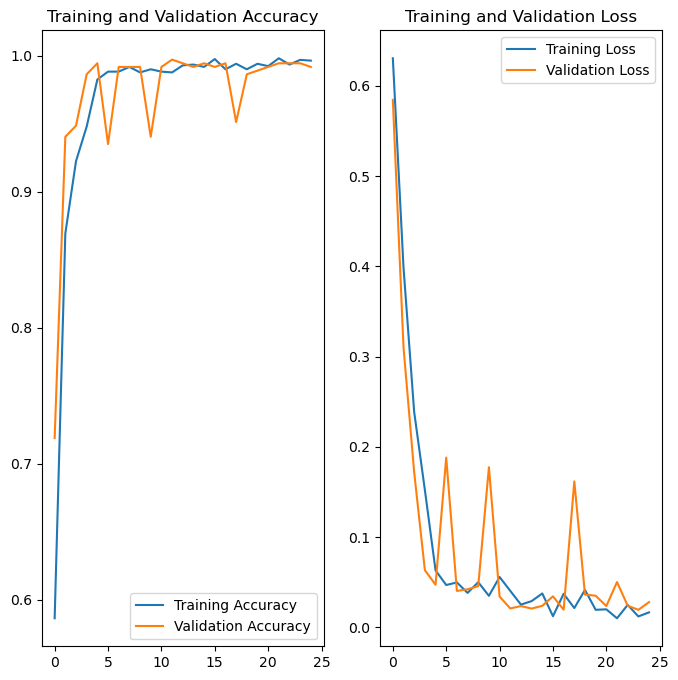

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
# We see Reducing Training and Validation loss

### Write a function for inference

In [29]:
from tensorflow.keras.preprocessing import image as keras_image

def predict(model, class_names, img):
    # Preprocess the image
    target_size = (256, 256)  # Replace with your desired target size
    img = keras_image.array_to_img(img)
    resized_img = img.resize(target_size)
    resized_img_array = keras_image.img_to_array(resized_img)
    resized_img_array = np.expand_dims(resized_img_array, axis=0)  # Add batch dimension
    preprocessed_img = resized_img_array / 255.0  # Normalize pixel values
    
    # Make prediction
    predictions = model.predict(x=preprocessed_img,verbose=0)
    
    # Get predicted class and confidence
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return predicted_class, confidence

In [30]:
class_names = ['Pepper bell Bacterial spot', 'Pepper bell healthy']

##### Run prediction on a sample image

In [31]:
test_batch = test_generator.next()
test_images, test_labels = test_batch

**Now run inference on few sample images**

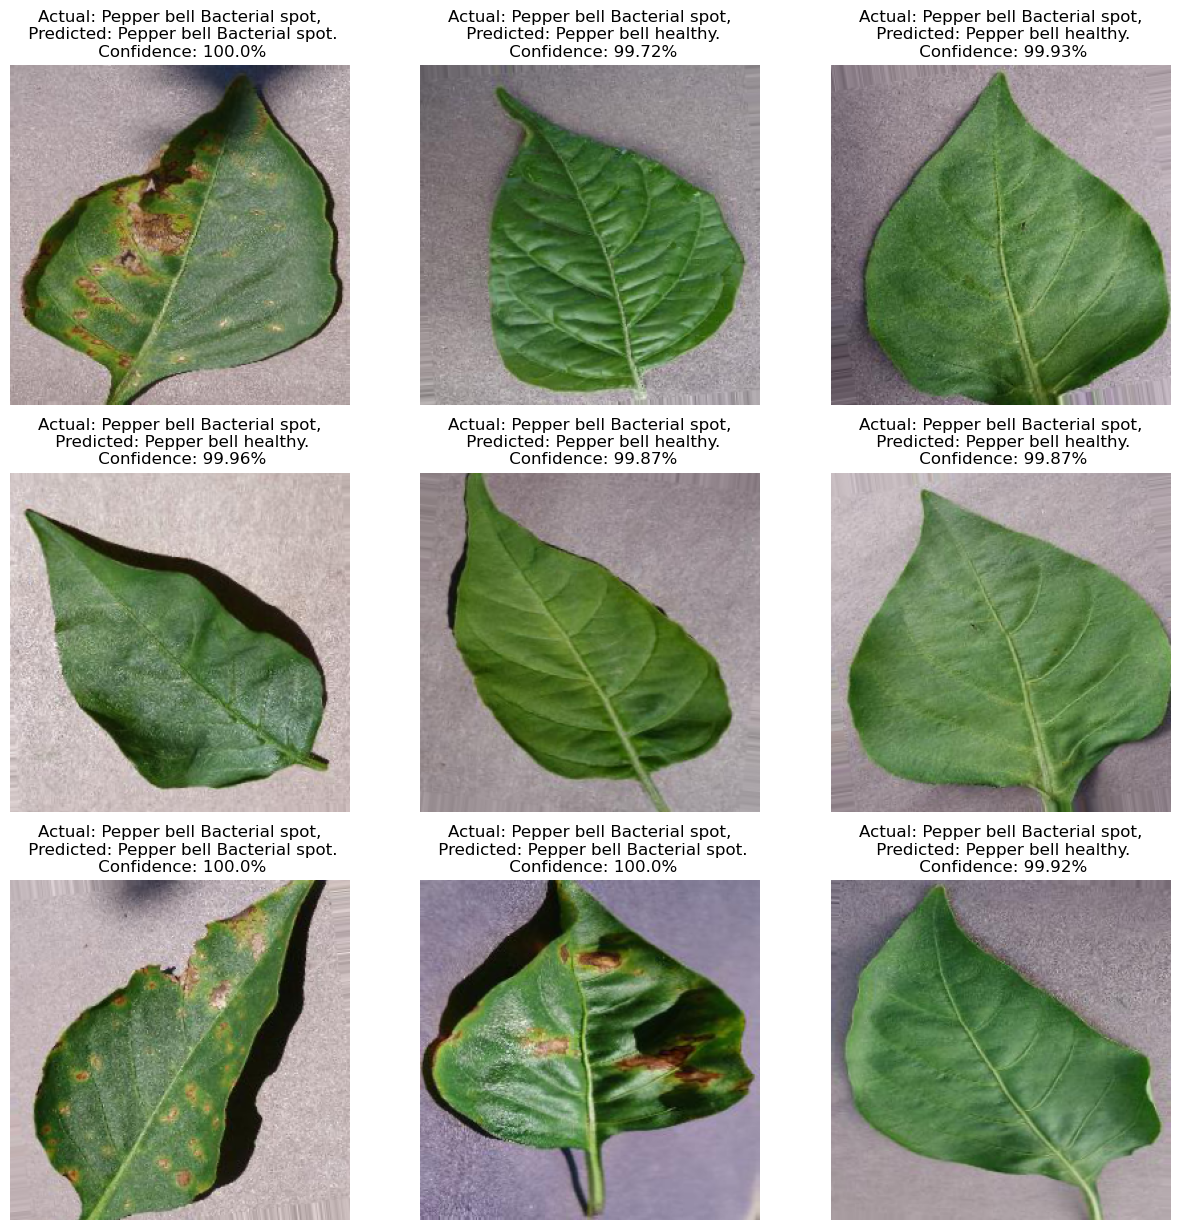

In [32]:
plt.figure(figsize=(15, 15))

# Number of images to display
num_images = 9
images_displayed = 0  # Counter to track displayed images

# Read and display images
for _ in range(num_images):
    test_batch = test_generator.next()
    for i in range(len(test_batch[0])):
        test_image = test_batch[0][i]  # Accessing the image
        
        ax = plt.subplot(3, 3, i + 1)   # 9 images displaying into 3*3 subplot
        plt.imshow(test_image)
        
        predicted_class, confidence = predict(model,class_names, test_image)
        actual_class = class_names[np.argmax(test_batch[1][0])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis('off')  # Remove axis from image
        
        images_displayed += 1
        if images_displayed >= num_images: # Conditions to break the loop
            break
    if images_displayed >= num_images:
        break

### Saving the Model and its INFO according to your versions

In [46]:
import os,json

model_folder = "saved_models/PepperLeaf/FinalVersion"
model_name = "PepperLeaf_model.h5"

In [47]:
#Saving model and its history in 
os.makedirs(model_folder,exist_ok=True)
model.save(os.path.join(model_folder,model_name))

history_dict=history.history
with open(os.path.join(model_folder, 'history.json'), 'w') as json_file:
    json.dump(history_dict, json_file)
    
with open(os.path.join(model_folder, 'classification_report.txt'), 'w') as file:
    file.write(report)

In [7]:
loaded_model = load_model(r"saved_models/PepperLeaf/FinalVersion/PepperLeaf_model.h5")

### on test data

In [20]:
true_y = []
pred_y = []

# Iteratig over test_generator for true labels and predictions for the entire test set
for i in range(len(test_generator)):
    test_batch = test_generator.next()
    
    true_classes = [np.argmax(y) for y in test_batch[1]]
    true_y.extend([class_names[int(label)] for label in true_classes])

    batch_predictions = model.predict(test_batch[0],verbose=False)
    pred_classes = [np.argmax(pred) for pred in batch_predictions]
    pred_y.extend([class_names[pred] for pred in pred_classes])

    
# Confusion Matrix and classification report
cfm = confusion_matrix(true_y,pred_y)  
print("Confusion Matrix:\n")
print(cfm)
print('-'*108)

report = classification_report(true_y, pred_y, target_names=class_names)
print("Classification Report:\n",report)

Confusion Matrix:

[[150   1]
 [  0 223]]
------------------------------------------------------------------------------------------------------------
Classification Report:
                             precision    recall  f1-score   support

Pepper bell Bacterial spot       1.00      0.99      1.00       151
       Pepper bell healthy       1.00      1.00      1.00       223

                  accuracy                           1.00       374
                 macro avg       1.00      1.00      1.00       374
              weighted avg       1.00      1.00      1.00       374



### on train data

In [8]:
true_y = []
pred_y = []

# Iteratig over train_generator for true labels and predictions for the entire train set
for i in range(len(train_generator)):
    train_batch = train_generator.next()
    
    true_classes = [np.argmax(y) for y in train_batch[1]]
    true_y.extend([class_names[int(label)] for label in true_classes])

    batch_predictions = loaded_model.predict(train_batch[0],verbose=False)
    pred_classes = [np.argmax(pred) for pred in batch_predictions]
    pred_y.extend([class_names[pred] for pred in pred_classes])

    
# Confusion Matrix and classification report
cfm = confusion_matrix(true_y,pred_y)  
print("Confusion Matrix:\n")
print(cfm)
print('-'*108)

report = classification_report(true_y, pred_y, target_names=class_names)
print("Classification Report:\n",report)

Confusion Matrix:

[[ 694    3]
 [   1 1033]]
------------------------------------------------------------------------------------------------------------
Classification Report:
                             precision    recall  f1-score   support

Pepper bell Bacterial spot       1.00      1.00      1.00       697
       Pepper bell healthy       1.00      1.00      1.00      1034

                  accuracy                           1.00      1731
                 macro avg       1.00      1.00      1.00      1731
              weighted avg       1.00      1.00      1.00      1731

